In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
%matplotlib inline
plt.viridis()

In [182]:
# Membrane
v_rest = -70 * mvolt #mV
e_ext = 0 * mvolt #V
v_thr = -54 * mvolt #mV
g_max = 0.2
tau_m = 20* ms #ms
tau_ex = 5* ms #ms
e = np.e
g = g_max
pre_t = 0 * ms
rate = 200 * Hz


# STDP
Apre = a_plus = 0.1
b = 1.2
taupre = tau_plus = 20 * ms #ms
taupost = tau_minus = 64 * ms #ms
Apost = a_minus = (a_plus * tau_plus * b) / tau_minus

0. s 5. ms 10. ms 15. ms 20. ms 25. ms 30. ms 35. ms 40. ms 45. ms 50. ms 55. ms 60. ms 65. ms 70. ms 75. ms 80. ms 85. ms 90. ms 95. ms rate =  0. Hz


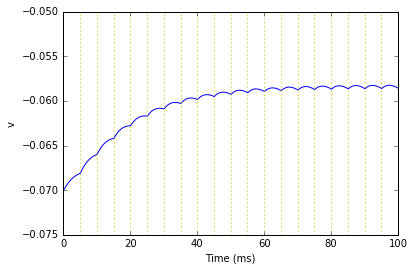

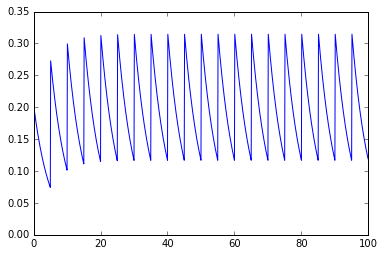

In [183]:
start_scope()
eqs = '''
dv/dt = (v_rest-v + gex * (e_ext - v))/tau_m : volt
dgex/dt = -gex/tau_ex: 1
'''
G = NeuronGroup(1, eqs, threshold='v > -54 * mV',
                reset='v = -70 * mV', method='euler', dt=0.1 * ms)#, events={'trigger_stdp' : 'v > v_thr'})
G.v = -70*mV
G.gex = 0.0
# G.run_on_event('trigger_stdp', 'x=0')
# event_mon = EventMonitor(group, 'trigger_stdp')
statemon = StateMonitor(G, ['v', 'gex',], record=0)
spikemon = SpikeMonitor(G)



# Pre pop
gap = 100 * ms / (rate  * (100 *ms))
times = np.arange(rate  * (100 *ms)) * gap
inp = SpikeGeneratorGroup(1, [0] * len(times), times)

# Connection from pre pop
feedforward = Synapses(inp, G, 
                 '''
                 w : 1
                 dapre/dt = -apre/taupre : 1 (event-driven)
                 dapost/dt = -apost/taupost : 1 (event-driven)
                 ''', 
                 on_pre=
                 '''
                 gex_post += w
                 apre += Apre
                 w = clip(w+apost, 0, g_max)
                 ''',
                 on_post='''
                 apost += Apost
                 w = clip(w+apre, 0, g_max)
                 ''')
feedforward.connect(j='i')
feedforward.w = g
# feedforward.g = g_max



# G.g = linked_var(feedforward, 'g')
# print G.g


inp_spikemon = SpikeMonitor(inp)

run(100*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='r', lw=3)
    print t,
for t in inp_spikemon.t:
    axvline(t/ms, ls=':', c='y', lw=1)
    print t,
xlabel('Time (ms)')
ylabel('v')
ylim([-.075, -.05])
figure()
plot(statemon.t/ms, statemon.gex[0])
print "rate = ", len(spikemon.t) / (100 * ms)

<spikemonitor_2.t: array([ 0.]) * second>

In [100]:
np.arange(rate  * (100 *ms)) * 10 * ms

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
        180.,  190.]) * msecond

In [110]:
print times

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.] ms


In [154]:
rate  * (100 *ms)

20.0

In [155]:
rate

200. * hertz

In [157]:
100 * ms / (rate  * (100 *ms))

5. * msecond

In [161]:
np.arange(rate  * (100 *ms))

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.])